In [1]:
%pylab inline

import cvxpy
from cvxpy import Variable, Minimize, sum_squares, pnorm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('../../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

def read_data(filename):

    # read the boundary points and get a mask
    raw_data = np.loadtxt(filename,skiprows=0)
    coords = raw_data[:,:2]
    deflection = raw_data[:,2]
    boundary = raw_data[:,3]
    return  coords, deflection, boundary


Populating the interactive namespace from numpy and matplotlib


In [2]:
pdata = pd.read_csv("./t2_generated.csv")


In [3]:
CUTOFF  = 12
N_SOLUTIONS = 64
gamma_vals = np.logspace(-4, -1, N_SOLUTIONS)



coords = np.array([pdata.x , pdata.y]).T
deflection_x = np.array(pdata.u_x)
deflection_y = np.array(pdata.u_y)
boundary = np.array(pdata.boundary)

x_obs_positions = sorted(set(coords[:, 0]))
y_obs_positions = sorted(set(coords[:, 1]))

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

N = len(x_obs_positions)
M = len(y_obs_positions)

boundary2d = boundary.reshape((N, M))
mask = np.zeros(boundary2d.shape)
for r in range(boundary2d.shape[1]):
    pts = np.where(boundary2d[:, r] == 1)
    
    if (len(pts[0]) > 0):
        mini = (min(min(pts)))
        maxi = max(max(pts))
        mask[ mini:maxi, r] = 1

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()

condition_inside = distances2d<=10
condition_outside = (distances2d>10) * (distances2d<=CUTOFF+10)

del distances2d, mask, boundary2d
gc.collect()



0

In [4]:
x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)


Size of the problem is 5183


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [5]:

obs_x_in = deflection_x[condition_inside]
obs_x_out = deflection_x[condition_outside]

obs_y_in = deflection_y[condition_inside]
obs_y_out = deflection_y[condition_outside]

n_in = len(x_in)
n_out = len(x_out)


gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma = Variable(n_in,2)
predicted_in_x = G_in_in_xx * sigma[:,0] + G_in_in_xy * sigma[:,1]
predicted_out_x = G_out_in_xx * sigma[:,0] + G_out_in_xy * sigma[:,1]
predicted_in_y = G_in_in_yx * sigma[:,0] + G_in_in_yy * sigma[:,1]
predicted_out_y = G_out_in_yx * sigma[:,0] + G_out_in_yy * sigma[:,1]

error = sum_squares(obs_x_in - predicted_in_x) + sum_squares(obs_x_out - predicted_out_x) + \
    sum_squares(obs_y_in - predicted_in_y) + sum_squares(obs_y_out - predicted_out_y)

forceconstraints = [sum_entries(sigma[:,0])==0, sum_entries(sigma[:,1])==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma[:,1]) - mul_elemwise(y_in-y_center,sigma[:,0]))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []


$$
\int_\Omega \vert \sigma \vert \mathrm{d}\mathbf{x} 
$$

In [6]:
regularity_penalty = sum_entries(pnorm(sigma,2, axis=1))
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_values = []

u_x_values = []


In [7]:
#num_cores = multiprocessing.cpu_count() - 4
num_cores = 2

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-7, reltol = 1e-6,
                   abstol = 1e-7)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_values.append(sigma.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside].flat = sigma[:,0].value.reshape((n_in,))
    s_y[condition_inside].flat = sigma[:,1].value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside].flat = predicted_in_x.value
    u_x[condition_outside].flat = predicted_out_x.value
    u_y[condition_inside].flat = predicted_in_y.value
    u_y[condition_outside].flat = predicted_out_y.value
    
    return np.array([sigma[:,0].value, sigma[:,1].value]).T, error.value, regularity_penalty.value, val

#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)
pad_results = [invert_one(val) for val in gamma_vals]

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  3e+01  1e+00
 1:  3.3491e-01  2.4004e-01  1e+02  4e-01  2e+00  2e-01
 2:  3.1725e-01  2.6772e-01  1e+01  8e-02  3e-01  6e-03
 3:  2.3845e-01  2.3794e-01  1e-01  8e-03  3e-02  5e-03
 4:  2.3477e-01  2.3399e-01  9e-03  1e-03  4e-03  7e-05
 5:  2.3255e-01  2.3251e-01  5e-04  1e-04  5e-04  7e-05
 6:  2.3248e-01  2.3247e-01  7e-05  2e-05  8e-05  1e-05
 7:  2.3247e-01  2.3247e-01  8e-06  2e-06  9e-06  1e-06
 8:  2.3247e-01  2.3247e-01  1e-07  4e-08  2e-07  2e-08
 9:  2.3247e-01  2.3247e-01  2e-09  7e-10  3e-09  3e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  3e+01  1e+00
 1:  3.4712e-01  2.4225e-01  1e+02  4e-01  2e+00  2e-01
 2:  3.2246e-01  2.7042e-01  1e+01  8e-02  3e-01  7e-03
 3:  2.3912e-01  2.3858e-01  1e-01  8e-03  3e-02  6e-03
 4:  2.3505e-01  2.3425e-01  9e-03  1e-03  4e-03  9e-05
 5:  2.3283e-01  2.3278e-01 

 6:  2.3703e-01  2.3705e-01  2e-04  7e-05  3e-04  7e-05
 7:  2.3702e-01  2.3703e-01  2e-05  5e-06  2e-05  5e-06
 8:  2.3702e-01  2.3702e-01  8e-07  3e-07  1e-06  3e-07
 9:  2.3702e-01  2.3702e-01  8e-08  3e-08  1e-07  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  3e+01  1e+00
 1:  5.7456e-01  2.8783e-01  2e+02  8e-01  3e+00  3e-01
 2:  3.7196e-01  3.1563e-01  9e+00  1e-01  4e-01  3e-02
 3:  2.5227e-01  2.5269e-01  2e-01  2e-02  6e-02  1e-02
 4:  2.3960e-01  2.3964e-01  9e-03  2e-03  8e-03  2e-03
 5:  2.3776e-01  2.3783e-01  9e-04  3e-04  1e-03  3e-04
 6:  2.3774e-01  2.3775e-01  1e-04  4e-05  2e-04  4e-05
 7:  2.3774e-01  2.3775e-01  2e-05  7e-06  3e-05  7e-06
 8:  2.3774e-01  2.3774e-01  4e-06  1e-06  5e-06  1e-06
 9:  2.3774e-01  2.3774e-01  7e-07  2e-07  9e-07  2e-07
10:  2.3774e-01  2.3774e-01  4e-08  1e-08  4e-08  9e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: 

 8:  2.5148e-01  2.5150e-01  3e-04  8e-05  3e-04  7e-05
 9:  2.5150e-01  2.5150e-01  4e-05  1e-05  5e-05  1e-05
10:  2.5150e-01  2.5150e-01  9e-06  3e-06  9e-06  2e-06
11:  2.5150e-01  2.5150e-01  4e-07  1e-07  4e-07  9e-08
12:  2.5150e-01  2.5150e-01  4e-08  1e-08  4e-08  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  3e+01  1e+00
 1:  7.0919e-01  3.4448e-01  2e+02  1e+00  4e+00  5e-01
 2:  4.2552e-01  3.8049e-01  8e+00  2e-01  7e-01  9e-02
 3:  2.8086e-01  2.8513e-01  5e-01  4e-02  2e-01  4e-02
 4:  2.6003e-01  2.5973e-01  4e-02  8e-03  3e-02  5e-03
 5:  2.6001e-01  2.6043e-01  5e-02  9e-03  3e-02  7e-03
 6:  2.5352e-01  2.5384e-01  4e-03  1e-03  4e-03  1e-03
 7:  2.5379e-01  2.5386e-01  8e-04  2e-04  9e-04  2e-04
 8:  2.5385e-01  2.5387e-01  5e-04  1e-04  5e-04  1e-04
 9:  2.5387e-01  2.5388e-01  8e-05  2e-05  9e-05  2e-05
10:  2.5388e-01  2.5388e-01  2e-05  6e-06  2e-05  4e-06
11:  2.5388e-01  2.5388e-0

14:  2.8576e-01  2.8576e-01  4e-08  1e-08  4e-08  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  3e+01  1e+00
 1:  2.6212e-01  3.1635e-01  1e+02  1e+00  4e+00  8e-01
 2:  4.5061e-01  4.2687e-01  5e+00  2e-01  7e-01  1e-01
 3:  3.2048e-01  3.5976e-01  2e+00  1e-01  4e-01  1e-01
 4:  2.8559e-01  3.0138e-01  1e-01  2e-02  9e-02  3e-02
 5:  2.8097e-01  3.0221e-01  2e-01  3e-02  1e-01  4e-02
 6:  2.8787e-01  2.9069e-01  1e-02  3e-03  1e-02  5e-03
 7:  2.9082e-01  2.9158e-01  4e-03  1e-03  4e-03  1e-03
 8:  2.9140e-01  2.9180e-01  2e-03  6e-04  2e-03  8e-04
 9:  2.9190e-01  2.9198e-01  5e-04  1e-04  5e-04  2e-04
10:  2.9200e-01  2.9202e-01  1e-04  3e-05  1e-04  4e-05
11:  2.9202e-01  2.9203e-01  3e-05  7e-06  3e-05  9e-06
12:  2.9203e-01  2.9203e-01  5e-06  1e-06  4e-06  1e-06
13:  2.9203e-01  2.9203e-01  3e-07  7e-08  3e-07  8e-08
14:  2.9203e-01  2.9203e-01  1e-08  3e-09  1e-08  3e-09
Optimal solution found.
  

 4:  3.7441e-01  3.8186e-01  3e-02  4e-03  1e-02  1e-02
 5:  3.8799e-01  3.8942e-01  5e-03  8e-04  3e-03  2e-03
 6:  3.8995e-01  3.9044e-01  2e-03  3e-04  1e-03  7e-04
 7:  3.9094e-01  3.9102e-01  4e-04  6e-05  2e-04  1e-04
 8:  3.9112e-01  3.9113e-01  4e-05  6e-06  2e-05  1e-05
 9:  3.9114e-01  3.9114e-01  8e-06  1e-06  4e-06  2e-06
10:  3.9114e-01  3.9114e-01  2e-06  4e-07  1e-06  6e-07
11:  3.9114e-01  3.9114e-01  1e-06  1e-07  5e-07  2e-07
12:  3.9114e-01  3.9114e-01  7e-08  1e-08  4e-08  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  2e+01  1e+00
 1: -5.8775e-01 -2.0378e-01  9e+01  1e+00  4e+00  1e+00
 2:  2.4523e-01  3.9129e-01  3e+00  2e-01  6e-01  3e-01
 3:  3.2041e-01  3.7202e-01  2e-01  3e-02  1e-01  7e-02
 4:  3.9110e-01  3.9846e-01  3e-02  4e-03  1e-02  1e-02
 5:  4.0577e-01  4.0713e-01  5e-03  8e-04  3e-03  2e-03
 6:  4.0780e-01  4.0826e-01  2e-03  3e-04  1e-03  7e-04
 7:  4.0880e-01  4.0888e-0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  2e+01  1e+00
 1: -3.6628e+00 -1.9943e+00  8e+01  1e+00  3e+00  2e+00
 2: -6.2084e-01  6.3284e-02  4e+00  2e-01  5e-01  8e-01
 3:  4.6276e-01  5.6184e-01  4e-01  3e-02  7e-02  1e-01
 4:  6.8314e-01  6.9855e-01  6e-02  4e-03  1e-02  2e-02
 5:  7.2248e-01  7.2524e-01  1e-02  7e-04  2e-03  3e-03
 6:  7.2776e-01  7.2865e-01  4e-03  2e-04  7e-04  1e-03
 7:  7.3023e-01  7.3038e-01  8e-04  5e-05  1e-04  2e-04
 8:  7.3069e-01  7.3071e-01  1e-04  6e-06  2e-05  2e-05
 9:  7.3075e-01  7.3075e-01  1e-05  7e-07  2e-06  3e-06
10:  7.3075e-01  7.3075e-01  3e-06  2e-07  5e-07  7e-07
11:  7.3075e-01  7.3075e-01  7e-07  4e-08  1e-07  1e-07
12:  7.3075e-01  7.3075e-01  2e-07  1e-08  3e-08  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -4.0000e+00  4e+03  7e+00  2e+01  1e+00
 1: -4.5792e+00 -2.5064e+00  8e+01  1e+00  3e+00  3e+00
 2: -5.8146e-01  1.0171e-01 

 1: -5.5067e+01 -3.1731e+01  2e+02  2e+00  3e+00  2e+01
 2: -1.6602e+00  5.0858e-01  1e+01  2e-01  3e-01  2e+00
 3:  8.0508e-01  1.1321e+00  1e+00  3e-02  4e-02  3e-01
 4:  1.2781e+00  1.3934e+00  4e-01  1e-02  1e-02  1e-01
 5:  1.3274e+00  1.4180e+00  4e-01  8e-03  1e-02  1e-01
 6:  1.5020e+00  1.5190e+00  8e-02  2e-03  2e-03  2e-02
 7:  1.5307e+00  1.5351e+00  2e-02  5e-04  6e-04  5e-03
 8:  1.5381e+00  1.5394e+00  7e-03  2e-04  2e-04  1e-03
 9:  1.5402e+00  1.5407e+00  3e-03  6e-05  9e-05  5e-04
10:  1.5414e+00  1.5414e+00  6e-04  1e-05  2e-05  9e-05
11:  1.5416e+00  1.5416e+00  9e-05  2e-06  2e-06  1e-05
12:  1.5416e+00  1.5416e+00  5e-06  1e-07  1e-07  8e-07
13:  1.5416e+00  1.5416e+00  4e-07  7e-09  1e-08  5e-08
Optimal solution found.


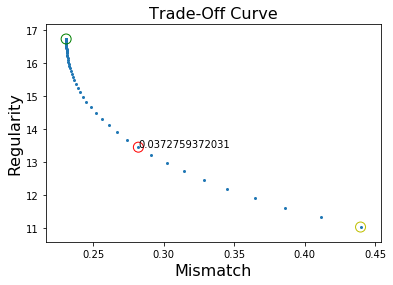

In [8]:
data_error = [res[1] for res in pad_results ]
reg_error = [res[2] for res in pad_results ]
lvals = [res[3] for res in pad_results ]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.scatter( data_error, reg_error,s=4)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

(119.94999999999999, 209.71000000000001)

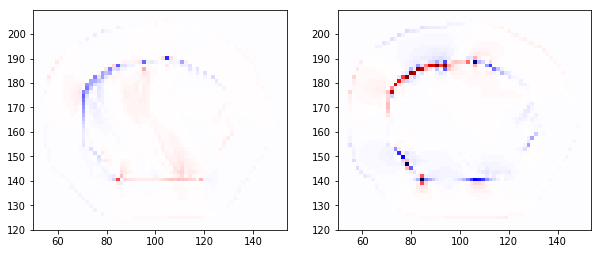

In [9]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = pad_results[best][0][0][:,0]
s_y[condition_inside] = pad_results[best][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))*.5

x_min = min(coords[boundary == 1, 0])
x_max = max(coords[boundary == 1, 0])
y_min = min(coords[boundary == 1, 1])
y_max = max(coords[boundary == 1, 1])

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))
plt.subplot(222)


plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude).axes.set_aspect('equal')

 
plt.xlim((x_min - 20, x_max + 20))
plt.ylim((y_min - 20, y_max + 20))

In [10]:
import pickle
import gzip

with gzip.open('../results/isotropic_L1_synthetic_results_expanded.gz','wb') as f:
    pickle.dump(pad_results + [ [x_obs_positions,y_obs_positions]],f)

In [19]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


In [46]:
results_1 = pickle.load(gzip.open('../results/isotropic_L1_synthetic_results_x_expanded.gz', 'rb'))
results_2 = pickle.load(gzip.open('../results/isotropic_L1_synthetic_results_expanded.gz', 'rb'))
results_3 = pickle.load(gzip.open('../results/anisotropic_L1_results.gz','rb'))
results = [results_1, results_2, results_3]
labels = ["x-only","both", "truth"]



In [63]:
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

x_1 = results[0][-1][0]
y_1 = results[0][-1][1]
for rel in results: del(rel[-1])
x_min, x_max = 69.974999999999994, 133.72999999999999
y_min, y_max = 139.94999999999999, 189.71000000000001

[39, 43, 4]


[39, 43, 4]

0
1
2


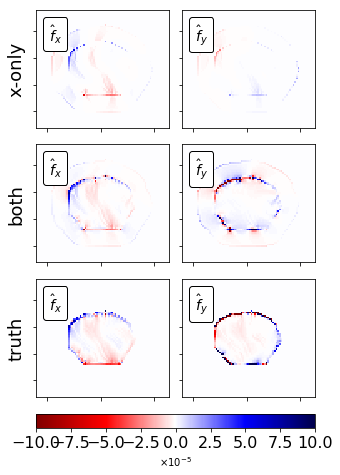

In [64]:
fig = plt.figure(figsize=(5,8))
#fig = plt.figure()
maxmagnitude = 10
gs0 = gridspec.GridSpec(3,1, hspace = 0.1,wspace=0.1)

gs_j = []
gs_j_innergrids = []
ax = []
im = []


for j in range(3):
    print(j)
    gs_j += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=gs0[j,0],
                  hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
    
    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])

    try:
        s_x[condition_inside] = results[j][best[j]][0][0][:,0] * 1e2
        s_y[condition_inside] = results[j][best[j]][0][0][:,1] * 1e2
    except:
        s_x = results[j][best[j]][0][:,0] * 1e2
        s_y = results[j][best[j]][0][:,1] * 1e2
    # form a new 2x1 subplot of the results
    
    ax += [plt.Subplot(fig, gs_j[j][0,0])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 30, x_max + 30))
    ax[-1].set_ylim((y_min - 30, y_max + 30))
    #ax[-1].set_ylabel(labels[j],fontsize=18)
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    ax[-1].set_ylabel(labels[j],fontsize=18)

    #plt.axis('off')
    
    at = AnchoredText("$\hat{f}_{x}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

    z = np.ma.masked_array(s_x, np.abs(s_x) < 1e-6)    
    im += [ax[-1].pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]
    
    im[-1].axes.set_aspect('equal')
    
    ax += [plt.Subplot(fig, gs_j[j][0,1])]
    fig.add_subplot(ax[-1])
    
    ax[-1].set_xlim((x_min - 30, x_max + 30))
    ax[-1].set_ylim((y_min - 30, y_max + 30))
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{f}_{y}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    z = np.ma.masked_array(s_y, np.abs(s_y) < 1e-6)        
    im += [ax[-1].pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))).T,
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]
    
    im[-1].axes.set_aspect('equal')
    
#ax[0].text(100,220,r"Unconstrained",fontsize=20)
#ax[2].text(120,220,r"Constrained",fontsize=20)

cb = fig.colorbar(im[0], ax = ax, fraction=0.06, pad=0.04, orientation='horizontal')
cb.ax.tick_params(labelsize=16)
cb.set_label(label=r"$\times 10^{-5}$")

plt.savefig("../../figures/fig11.pdf",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.15, dpi=400)    

In [62]:
best

[43, 46, 4]